In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
tf.__version__
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

In [3]:
dataset_name = 'MNIST'
n = 10

In [4]:
# LOAD Dataset
from exp.data_loader import load_image_data

X_train, X_test, Y_train, Y_test, _, _ = load_image_data(dataset_name,'.data/')

In [5]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
Y_train = tf.one_hot(Y_train,10)
Y_test = tf.one_hot(Y_test,10)

2022-07-29 09:31:15.827043: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# load Black Box

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)

##model building
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

early_stopping = EarlyStopping(patience=3)
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
#history = model.fit(
#    train_dataset,
#    validation_data=test_dataset,
#    epochs=100,
#    callbacks=[early_stopping],
#    verbose=2
#)
#def plot_metric(history, metric):
#    train_metrics = history.history[metric]
#    val_metrics = history.history['val_'+metric]
#    epochs = range(1, len(train_metrics) + 1)
#    plt.plot(epochs, train_metrics)
#    plt.plot(epochs, val_metrics)
#    plt.title('Training and validation '+ metric)
#    plt.xlabel("Epochs")
#    plt.ylabel(metric)
#    plt.grid()
#    plt.legend(["train_"+metric, 'val_'+metric])
#    plt.show()
#plot_metric(history, 'loss')
#model.save_weights(f'./blackboxes/{dataset_name}_tf_nn')
from sklearn.metrics import accuracy_score
model.load_weights(f'./blackboxes/{dataset_name}_tf_nn')
model.trainable = False
print(accuracy_score(np.argmax(model.predict(X_train),axis=1),np.argmax(Y_train,axis=1)))
print(accuracy_score(np.argmax(model.predict(X_test),axis=1),np.argmax(Y_test,axis=1)))

2022-07-29 09:31:20.351543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:127] None of the MLIR optimization passes are enabled (registered 2)


0.9973166666666666
0.9911


In [7]:
black_box = 'nn'
def predict(x, return_proba=False):
    if return_proba:
        return model.predict(x)
    else: return np.argmax(model.predict(x),axis=1).astype(int).ravel()
y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)

In [8]:
X_train = np.hstack((X_train.reshape(-1,28*28),y_train_pred))
X_test = np.hstack((X_test.reshape(-1,28*28),y_test_pred))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 10
batch_size = 4096
sigma = 5
max_epochs = 100
early_stopping = 3
learning_rate = 1e-3

idx_cat = None

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    #D = torch.cdist(Z,Z)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-10:],X[:,-10:])
    X = X[:, :-10]
    D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
    D_features = torch.cdist(X,X)
    D = D_features + D_class
    #D = torch.cdist(X,X)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [35]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_{dataset_name}.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_{dataset_name}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [10]:
model.load_state_dict(torch.load(f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

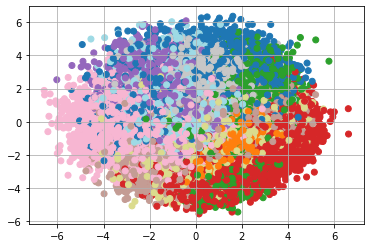

In [11]:
plt.scatter(Z_train[:,1], Z_train[:,2], c=np.argmax(y_train_pred,axis=1), cmap='tab20')
plt.grid()

In [40]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(Z_train, np.where(Y_train.numpy()==1)[1])
print(neigh.score(Z_train,np.where(Y_train.numpy()==1)[1]))
print(neigh.score(Z_test,np.where(Y_test.numpy()==1)[1]))

0.9541333333333334
0.9419


# Prototypes

In [23]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(Z_train, np.where(Y_train.numpy()==1)[1])
print(clf.score(Z_train,np.where(Y_train.numpy()==1)[1]))
print(clf.score(Z_test,np.where(Y_test.numpy()==1)[1]))

0.77365
0.7904


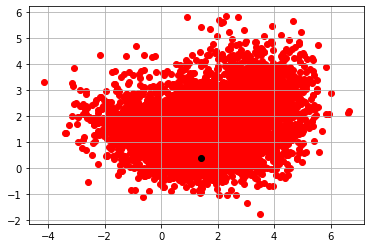

In [36]:
c = 3
a = 1
b = 3

idx = np.argmax(y_train_pred,axis=1)==3
plt.scatter(Z_train[idx,a], Z_train[idx,b], c='r')
plt.scatter(clf.centroids_[2,a], clf.centroids_[2,b], c='k')
plt.grid()